# Plot Scatter on Screenshot Pilatus


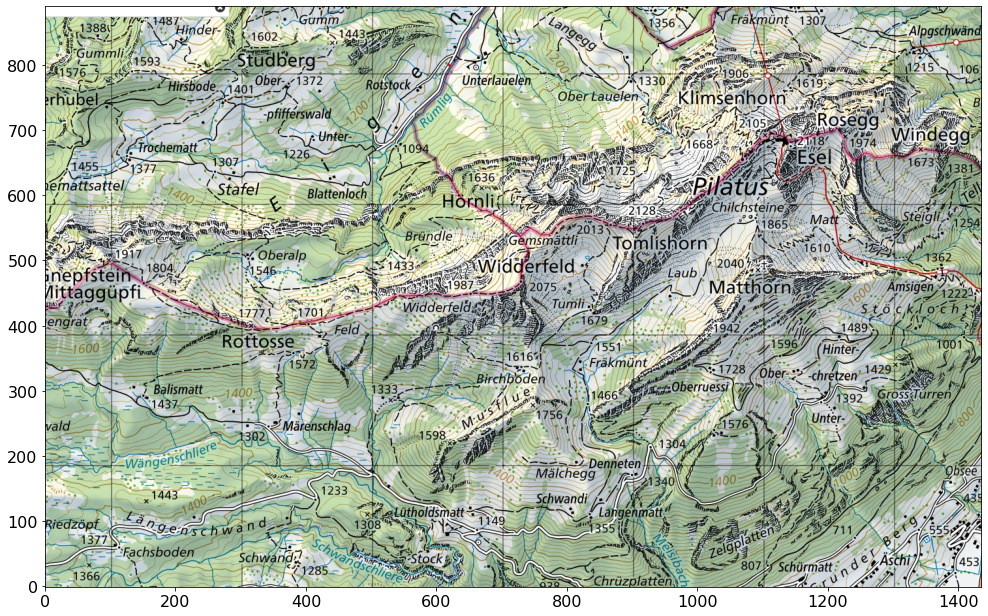

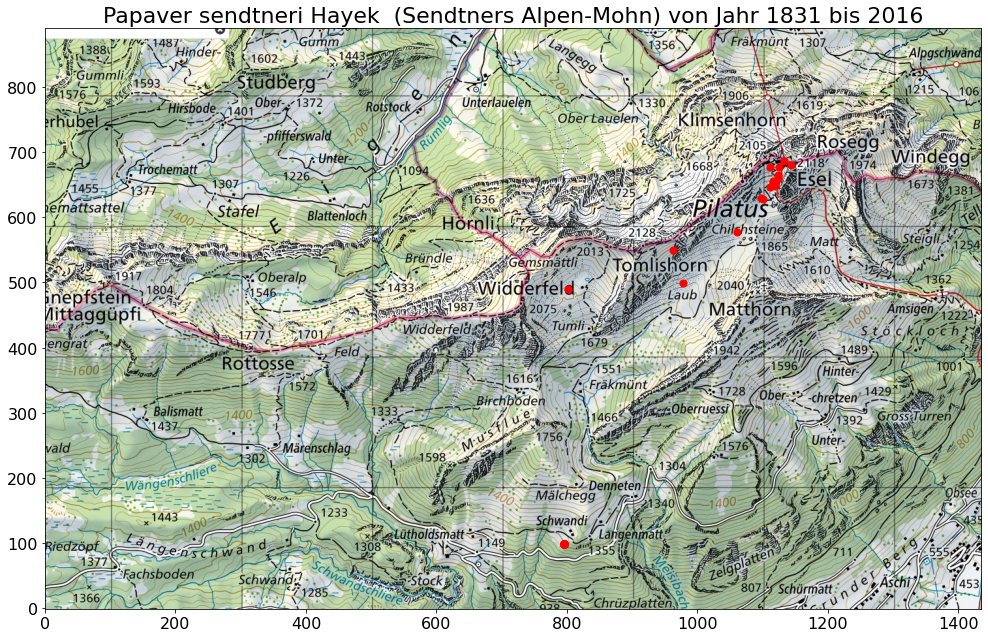

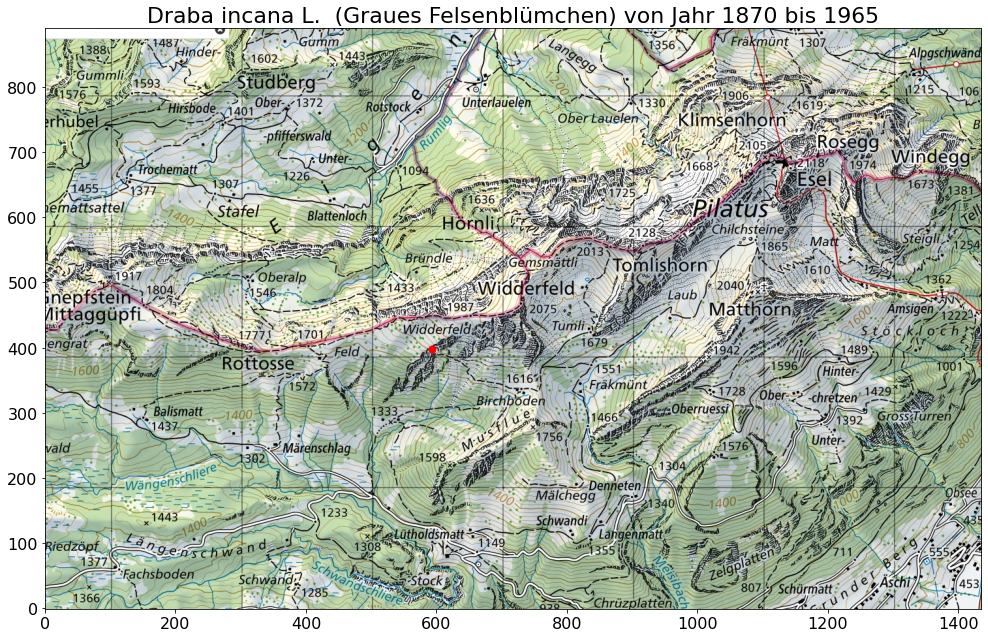

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline

#input_image = 'map1.png'

input_image = 'map_for_precise.png'

#input_csv = "MAR infoflora_200274_Pilatus.csv"

input_csv = "MAR infoflora_200274_precise.csv"

image_width = plt.imread(input_image).shape[1]
image_height= plt.imread(input_image).shape[0] 



breite = image_width / 100
hoehe = image_height / 100

def get_random_names(inp):
    name = inp['Trivialname'].to_list()
    return inp.sample(n = 40)

def swiss_to_WGS84(E, N):
	#  Nährungsformel für die Umrechnung von Schweizer Projektionskoordinaten in ellipsoidische WGS84 Koordinaten
	#  online converter admin.ch: https://www.swisstopo.admin.ch/en/maps-data-online/calculation-services/navref.html
    #  from https://www.google.ch/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjI44q72J_qAhVKxYUKHR8CAYYQFjAAegQIBhAB&url=https%3A%2F%2Fwww.swisstopo.admin.ch%2Fcontent%2Fswisstopo-internet%2Fde%2Fonline%2Fcalculation-services%2F_jcr_content%2FcontentPar%2Ftabs%2Fitems%2Fdokumente_und_publik%2FtabPar%2Fdownloadlist%2FdownloadItems%2F8_1467103085694.download%2Frefsys_d.pdf&usg=AOvVaw0JImHVi39dw5-Rs5KuN-KM

	y_strich = (E - 2600000)/1000000
	x_strich = (N - 1200000)/1000000
	

	lambda_strich = 2.6779094 + 4.728982 * y_strich + 0.791484 * y_strich *x_strich + 0.1306 * y_strich * x_strich**2 - 0.0436 * y_strich**3
	phi_strich = 16.9023892 + 3.238272 * x_strich -0.270978 * y_strich**2 - 0.002528 * x_strich**2 - 0.0447 * y_strich**2 * x_strich - 0.0140 * x_strich**3

	#Umrechnung der Länge und Breite in Einheit [°]

	lambda_neu = lambda_strich * 100 / 36 
	phi_neu = phi_strich * 100 / 36
    # NOTE: this formula is currently not usesd in the program 
	return (lambda_neu, phi_neu)

def map_numbers(value, leftMin, leftMax, rightMin, rightMax):
    #simply .map a number from one range to another
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin
    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - leftMin) / float(leftSpan)
    return rightMin + (valueScaled * rightSpan)

# convert coordinates to fit picture. 
# In this case, Point of origin (Koordinatenursprung) of picture = lowest value of all existing coordinates(x,y)
def convert_coordinates_x(x, minimum_x, maximum_x):
    # this function should be precise enough. 
    # Where it draws depends no x_min, y_min
    # x_min and y_min represent die untere linke Ecke des Screenshots. 
    
    """
Vorgehensweise
1) subtract x.min() and y.min() because the Nullpunt is x.min() and y.min() (is this accurate enough??)
    this gives values  0 to 8000 [x]
                       0 to 3000 [y]
                       
2)  map(0 to 8000, 0 to image-width)
    map(0 to 3000, 0 to image-height)
    
    Shouldn't be to hard to do. . .
"""
    x = x - minimum_x
    return map_numbers(x, 0, maximum_x - minimum_x, 0, image_width )

def convert_coordinates_y(y, minimum_y, maximum_y):
    y = y - minimum_y
    return map_numbers(y, 0, maximum_y - minimum_y, 0, image_height )

def get_all_entries_from_taxon(df, taxon):
    taxon_ = df.loc[df['Taxon'] == taxon]
    return taxon_
def get_taxonList(df):
    data = df['Taxon'].to_numpy()
    liste = []
    for item_n in data:
          #  no duplicates:
        if not item_n in liste:
            liste.append(item_n)
  
    return liste
    
def only_years_from_df(dataframe):
    return dataframe[['Jahr']].to_numpy()

def get_all_from_year(df, year):
    # example input = pd.DataFrame(plant_data), 2015
    df_all_from_year = df.loc[df['Jahr'] == year]
    return df_all_from_year
    
def get_all_from_name(df, name):
    # example input = pd.DataFrame(plant_data), 'Bewimperter Mannsschild'
    df_years = df.loc[df['Trivialname'] == name]
    return df_years
    
def get_all_x(df):
    return df[['Koordx']].to_numpy()

def get_all_x_of_year(df, year):
    df_x = df.loc[df['Jahr'] == year]
    return df_x[['Koordx']].to_numpy()

def get_all_y_of_year(df, year):
    df_y = df.loc[df['Jahr'] == year]
    return df_y[['Koordy']].to_numpy()

    
def make_dictionary(df):

    tax = df['Taxon'].to_numpy()
    trivial = df['Trivialname'].to_numpy()
    tax_nodup = []
    trival_nodup = []

    for line in tax:
        if not line in tax_nodup:
            tax_nodup.append(line)
      
    for line in trivial:
        if not line in trival_nodup:
            trival_nodup.append(line)
    
    zip_iterator = zip(tax_nodup, trival_nodup)
    # Get pairs of elements

    a_dictionary = dict(zip_iterator)
    return a_dictionary

plant_data = pd.read_csv(input_csv, sep=",", 
                         encoding="utf-8", 
                         usecols=['Koordx', 'Koordy', 'Trivialname', 'Jahr', 'Taxon'])

df = pd.DataFrame(plant_data)
df_row = df[['Koordx','Koordy','Trivialname', 'Jahr']]

dicti = make_dictionary(df)

# Array of all the x,y coordinates
x = df[['Koordx']].to_numpy() 
y = df[['Koordy']].to_numpy()


myfunc_vec_x = np.vectorize(convert_coordinates_x)
myfunc_vec_y = np.vectorize(convert_coordinates_y)
# vectorized function, to apply the same function to all array elements
# _mapped now contains all the coordinates in converted form 
x_mapped = myfunc_vec_x(x, x.min(), x.max())
y_mapped = myfunc_vec_y(y, y.min(), y.max())

all_x = get_all_x_of_year(df, 2015)

u, c = np.unique(all_x, return_counts=True)
dup = u[c > 1]

#print(dup)

large = 22; med = 16; small = 12

params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (breite*1.2, hoehe*1.2),
          'axes.labelsize': med,
          'axes.titlesize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)


frame2 = pd.DataFrame(get_random_names(plant_data))



colors= ['green', 'red', 'yellow', 'blue']
#plt.scatter(frame2['Koordx'], frame2['Koordy'])

# have to flip the image, before we specify point of origin=lower left (I don't know why, but it works)

im = np.flipud(plt.imread(input_image));
implot = plt.imshow(im, origin='lower', aspect='equal');



x_2015 = get_all_x_of_year(df, 2015)
y_2015 = get_all_y_of_year(df, 2015)

x_2015_mapped = myfunc_vec_x(x_2015, x_2015.min(), x_2015.max())
y_2015_mapped = myfunc_vec_y(y_2015, y_2015.min(), y_2015.max())

#plt.scatter(x_2015_mapped, y_2015_mapped, c='red', s=30, alpha=0.1)
#plt.scatter(x_mapped, y_mapped, c='red', s=30, alpha=0.1)

yearRangeSlider = widgets.IntRangeSlider(
    value=[1980, 2000],
    min=1949,
    max=2018,
    step=1,
    description='Jahr:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


out = widgets.Output(layout={'border': '1px solid black'})

select_plant = widgets.Dropdown(
    options=get_taxonList(df),
    description='Taxon:',
    disabled=False,
)

btn = widgets.Button(
    description='Zeichnen',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    icon='picture-o' # (FontAwesome names without the `fa-` prefix)
)

def is_empty(df):
    # returns 0 if dataframe is empty
    return len(df.index) == 0

def buttonEvent(inp):

    # maybe make an additional dropdown with 'Trivialname'
    
    tax = dropdown_value.widget_value
    years = yearRangeSlider.value
    all_taxon = get_all_entries_from_taxon(df, tax)
    
    #one liner to filter years by upper and lower range: 
    tax_from_years = all_taxon[(all_taxon.Jahr >= years[0]) & (all_taxon.Jahr <= years[1])] 
    with out:
        print('%s Einträge gefunden für %s' % (len(tax_from_years), tax))
    
    if len(tax_from_years) == 0:
        with out:
            print('0 Gefunden für %s. Evtl grösseren Jahr Bereich auswählen' % (tax))
            
        return None
    
    x = tax_from_years['Koordx'].to_numpy()
    y = tax_from_years['Koordy'].to_numpy()
    
    
    # Eckpunkte für myfunc_vec
    x_min = df[['Koordx']].to_numpy().min()
    y_min = df[['Koordy']].to_numpy().min()
    x_max = df[['Koordx']].to_numpy().max()
    y_max = df[['Koordy']].to_numpy().max()
        
   

    myfunc_vec_x = np.vectorize(convert_coordinates_x)
    myfunc_vec_y = np.vectorize(convert_coordinates_y)
    
    # vectorized function, to apply the same function to all array elements
    # _mapped now contains all the coordinates in converted form 
    x_mapped = myfunc_vec_x(x, x_min,  x_max)
    y_mapped = myfunc_vec_y(y, y_min, y_max)
    
    
    # draw the mapped points
    plt.scatter([x_mapped], [y_mapped], c='red', s=50, alpha=1)
    title = "%s  (%s) von Jahr %s bis %s" % (tax, dicti[tax], years[0], years[1])
    plt.title(title, loc='center')

   
    im = np.flipud(plt.imread(input_image));
    implot = plt.imshow(im, origin='lower', aspect='equal');
    final_image =  plt
    final_image.show()
    #set dpi to 300 for a slighter better image. However, it will be 50mb in size.
    filename = title + '.tiff'
    
    final_image.savefig(filename, dpi=None, quality=95, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)
    
    # ------------------ Button event finished ---------------------
    
btn.on_click(buttonEvent)

class Updated:
#   This class keeps track of the widget value (Dropdown) of select_plant 
#   Could be done by simply writing to a global, but trying to avoid using globals when possible 
    def __init__(self):
        # Initialize default value
            self.widget_value = "Agrimonia Eupatoria L."
    def update(self, val) -> None:
        self.widget_value = val
        
dropdown_value = Updated()
# dropdown_value.widget_value = Currently selected plant

def on_change(change):
    # dropdown value changed
    if change['type'] == 'change' and change['name'] == 'value':
        dropdown_value.update(change['new'])
        # Dropdown changed.
        # need to implement error handling: what if does not find the list??
        # numpy array of all existing years of that plant in the database
        
        #simply put the slider at approximately 2/3 [arbitrary  number] of the range, it just looks more presentable
        years = only_years_from_df(get_all_entries_from_taxon(df, change['new']))
        yearRangeSlider.min = years.min()
        yearRangeSlider.max = years.max()
        diff = years.max() - years.min()
        mini = np.around(years.min() + diff/3)
        maxi = np.around(years.min() + (diff/3) * 2)
        # set slider's min max default value 
        yearRangeSlider.value = [mini, maxi]

        
select_plant.observe(on_change, names='value')
#displaying the widets
widgets.VBox([yearRangeSlider,select_plant,btn, out])